## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

### TODO

o More labeled data

o Cancer as a subject or object. Does cancer fight the patient, or the other way around?

In [1]:
import os.path as op
from datetime import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sklearn.metrics import precision_score, recall_score

import re

In [2]:
DATA_PROCESSED = '../data/processed'

STYLE = '\033[41m' # red bg
END = '\033[0m'

### Load Projects and Labeled Keywords

In [3]:
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'combined_projects.csv'))

labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))

times = np.loadtxt("labeling_times.txt").tolist()

print(f'Total Projects DF: {len(all_projects):,}')
print(f'Total Labeled Keywords DF: {len(labeled):,}')
print(f'Total Unique Projects Labeled: {labeled.project_id.nunique():,}')

Total Projects DF: 10,096
Total Labeled Keywords DF: 9,758
Total Unique Projects Labeled: 5,476


### Stats

In [4]:
kickstarter_mask = all_projects['source'] == 'kickstarter'
gofundme_mask = all_projects['source'] == 'gofundme'
print(f'Kickstarter vs. GFM:\t {kickstarter_mask.mean()*100:.2f}% / {gofundme_mask.mean()*100:.2f}%')

ixs = all_projects.loc[kickstarter_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f'Metaphors per Kickstarter project: {len(filt) / len(ixs):.3f}')

ixs = all_projects.loc[gofundme_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f'Metaphors per GFM project: {len(filt) / len(ixs):.3f}')

p_hat = filt.mean()
project_n = labeled.loc[labeled['project_id'].isin(ixs), 'project_id'].nunique()
keyword_n = len(filt)
del ixs, filt

z005 = 2.575829

print()
print(f'Sample proportion of GFM metaphorical keywords:\t {p_hat*100:.2f}%')
print(f'99% CI:\t ({(p_hat - z005 * np.sqrt(p_hat * (1-p_hat) / keyword_n)) * 100:.2f}%, {(p_hat + z005 * np.sqrt(p_hat * (1-p_hat) / keyword_n)) * 100:.2f}%)')
print(f'GFM Projects N={project_n:,}, GFM Keywords N={keyword_n:,}')
print(f'For {p_hat*100:.2f}% +- 1%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.01**2):,}')
print(f'For {p_hat*100:.2f}% +- 0.5%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.005**2):,}')

Kickstarter vs. GFM:	 4.05% / 95.95%
Metaphors per Kickstarter project: 1.161
Metaphors per GFM project: 0.654

Sample proportion of GFM metaphorical keywords:	 93.42%
99% CI:	 (92.62%, 94.22%)
GFM Projects N=4,711, GFM Keywords N=6,340
For 93.42% +- 1%:	 n > 4,076
For 93.42% +- 0.5%:	 n > 16,307


https://metaphor.icsi.berkeley.edu/pub/en/index.php/Metaphor:CANCER_IS_A_JOURNEY

In [5]:
# these are ordered lists - since we search in order the lemma comes last (so not to catch non-lemma'd words)

BATTLE_WORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'defeat', 'winning', 'win']

JOURNEY_WORDS = ['path', 'journey']

window = 80

# Manually Label Metaphors

In [6]:
def find_keywords(text, source, source_type):
    '''
    Search `text` for all instances of keywords in `source`.
    '''
    if not isinstance(text, float):
        for kw in source:
            exp = r'\W(' + kw + ')\W'
            for kw_match in re.finditer(exp, text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

                prompt = text[start:kw_match.start()+1] + STYLE + text[kw_match.start()+1:kw_match.end()-1] + END + text[kw_match.end()-1:end]

                yield prompt, {'fragment': text[start:end], 
                               'char_location': float(kw_match.start()),
                               'kw_start': int(kw_match.start()) - int(start) + 1,
                               'type': source_type, 
                               'keyword': kw}
            
def metaphorical_response(total, current):
    res = input('Is this a cancer related metaphor? ')
    if len(res) == 2:
        pr = res[1]
        res = res[0]
        if pr == 'r':
            print(f"{current / total * 100:.2f}%")
            
    return res == 'y'

def exists_with_keyword(source, ix, char_location):
    '''
    Does the given project, with ID `ix`, exist in `source` with a keyword at `char_location`?
    '''
    return char_location in source.loc[source['project_id'] == ix, 'char_location'].values
    
def exists_without_keywords(source, ix):
    '''
    Does the given project, with ID `ix`, exist in `source` as a null (meaning, it has been seen previously
    and labeled as having no keywords)?
    '''
    locs = source.loc[source['project_id'] == ix, 'char_location']
    return len(locs) == 1 and sum(locs.isnull()) == 1

def unlabeled_projects():
    return all_projects.loc[~all_projects['id'].isin(labeled['project_id'])]

In [ ]:
up = unlabeled_projects()
c = total = int(input(f'N (max: {len(up):,}): '))

tp, fp, nan, projects = 0, 0, 0, 0

start = datetime.now()
        
for project in up.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    projects += 1
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
                
            c -= 1
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            if metaphorical_response(total, total - c):
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break
        
end = datetime.now()

times.append([(end - start).total_seconds(), projects])

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan} - Projects: {projects}')

Total time remaining: 4.113 hours


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


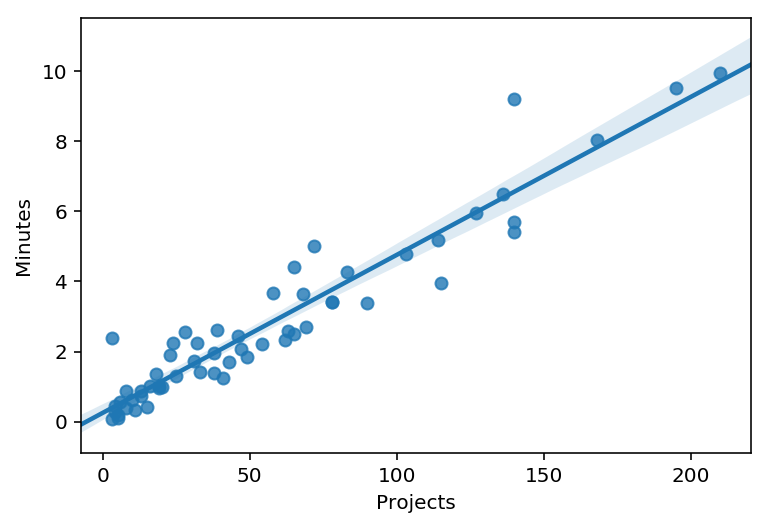

In [7]:
nptimes = np.array(times)
p = len(unlabeled_projects())
print(f"Total time remaining: {(nptimes[:, 0].sum() / nptimes[:, 1].sum()) * (1/60) * (1/60) * p:.3f} hours")

sns.regplot(x=nptimes[:, 1], y=nptimes[:, 0] / 60, order=1)
plt.ylabel('Minutes')
plt.xlabel('Projects')

np.savetxt("labeling_times.txt", nptimes)

Duplicates: 0
Total metaphor keywords: 6500


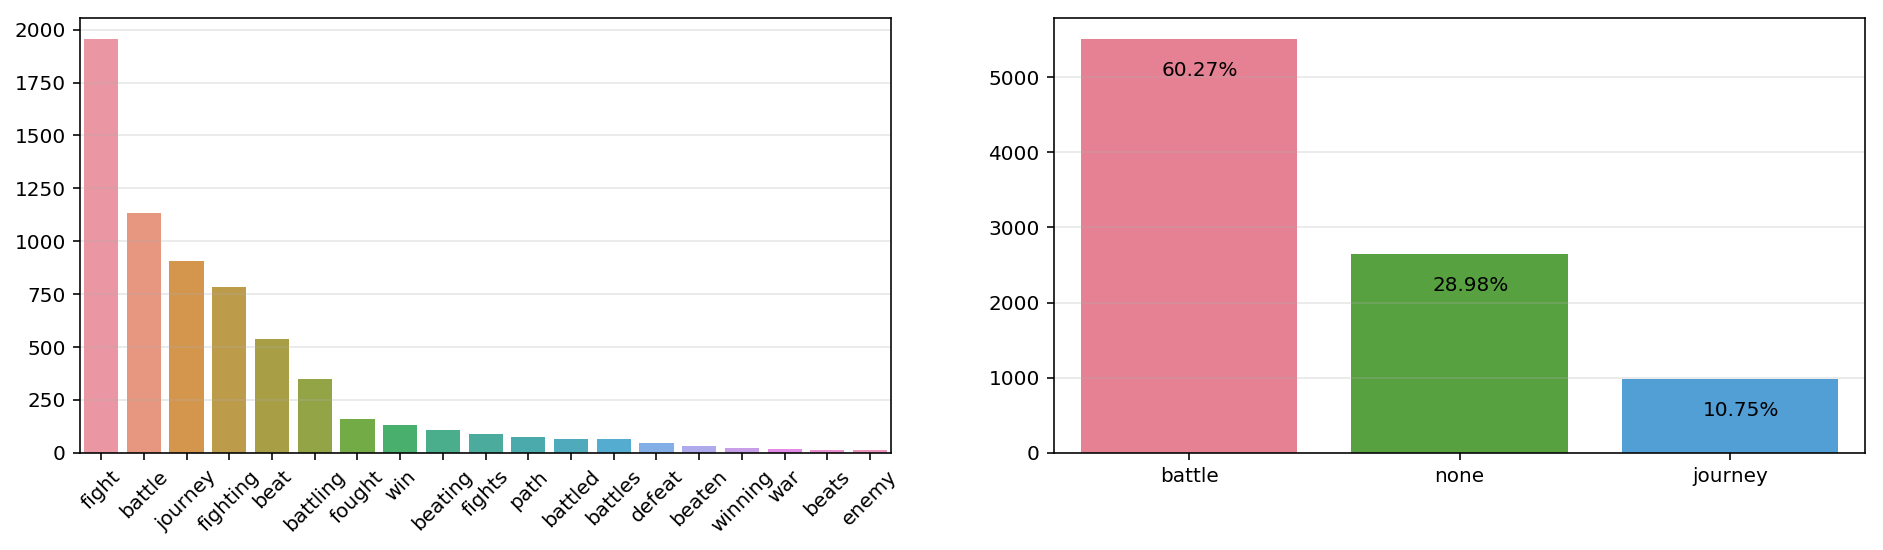

In [8]:
print(f'Duplicates: {labeled.duplicated().sum()}')
labeled = labeled.drop_duplicates()

print(f'Total metaphor keywords: {len(labeled.loc[labeled["metaphorical"] == True])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['metaphorical'] == True, 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled.loc[labeled['metaphorical'] != False, 'type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 500, f'{h/s*100:.2f}%')

In [ ]:
labeled.to_csv(op.join(DATA_PROCESSED, 'labeled.csv'), index=False)

# Auto-Detection

First attempt is with simple regular expressions.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
labeled_kw_exists = labeled.dropna()
train_ixs, test_ixs = train_test_split(np.arange(len(labeled_kw_exists)), train_size=0.8, stratify=labeled_kw_exists['metaphorical'])

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
def related_to_cancer(text):
    '''
    Does the given text contain cancer-related keywords?
    '''
    return 'cancer' in text or 'leukemia' in text or 'melanoma' in text or 'lymphoma' in text

def regex_find_metaphors(text):
    if not isinstance(text, float):
            
        if related_to_cancer(text.lower()):
                        
            for kw_match in re.finditer(r'\W(fight|fights|fighting|fought)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                next_ = text[kw_match.start():kw_match.end()+50].split()
#                 if text[kw_match.end()-1:kw_match.end()] in ['-', '/', '_']

                if len(next_) > 1 and re.match(r'(pain|depression|club|fear|anxiety|stress)', next_[1]):
                    continue
                
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': kw_match[1]}
                
            for kw_match in re.finditer(r'\W(battle|battles|battling|battled|beat|beats|beaten|beating|brutal)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                
                if kw_match.start() > 10 and text[kw_match.start()-10:kw_match.start()].split()[-1] in ['in', 'into']:
                    continue
                
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'battle', 
                        'keyword': kw_match[1]}
                
            if 'character' not in text.lower() and 'hero' not in text.lower():
                for kw_match in re.finditer(r'\W(enemy)\W', text.lower()):
                    start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'battle', 
                           'keyword': 'enemy'}
                    
            for kw_match in re.finditer(r'\W(path|destination)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'journey', 
                        'keyword': kw_match[1]}
                
        for kw_match in re.finditer(r'\W(journey)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
            prev_ = text[kw_match.start()-50:kw_match.end()].split()
            next_ = text[kw_match.start():kw_match.end()+50].split()

            if len(prev_) > 1 and ('will' in prev_):
                continue
                
            if len(next_) > 1 and (next_[1] in ['from', 'will', 'across'] or 'time' in next_):
                continue

            surround = text[kw_match.start()-50:kw_match.end()+50]
            if 'theatrical' in surround:
                continue

            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'journey', 
                   'keyword': 'journey'}
        
        for kw_match in re.finditer(r'\W(war (with|against|on) cancer|cancer war)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() - 8 + window)
            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'battle', 
                   'keyword': 'war'}
        

In [19]:
regex_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
regex_predicted_labeled['predicted'] = False

In [21]:
preds = []

for project in regex_predicted_labeled.itertuples():
    v = all_projects.loc[all_projects['id'] == project.project_id, 'text']
    if v.any():
        for metaphor in regex_find_metaphors(all_projects.loc[all_projects['id'] == project.project_id, 'text'].values[0]):
            if metaphor['char_location'] == project.char_location:
                regex_predicted_labeled.at[project.Index, 'predicted'] = True    

In the following charts, we hope to have all blue and no orange, or more realistically, large blue bars and small orange bars for each keyword.

The charts are broken into two: one for true metaphorical usage of the keyword, one for non-metaphorical usage of the keyword. Note that the x-axes are different because not every keyword in one of those groups in is the other.

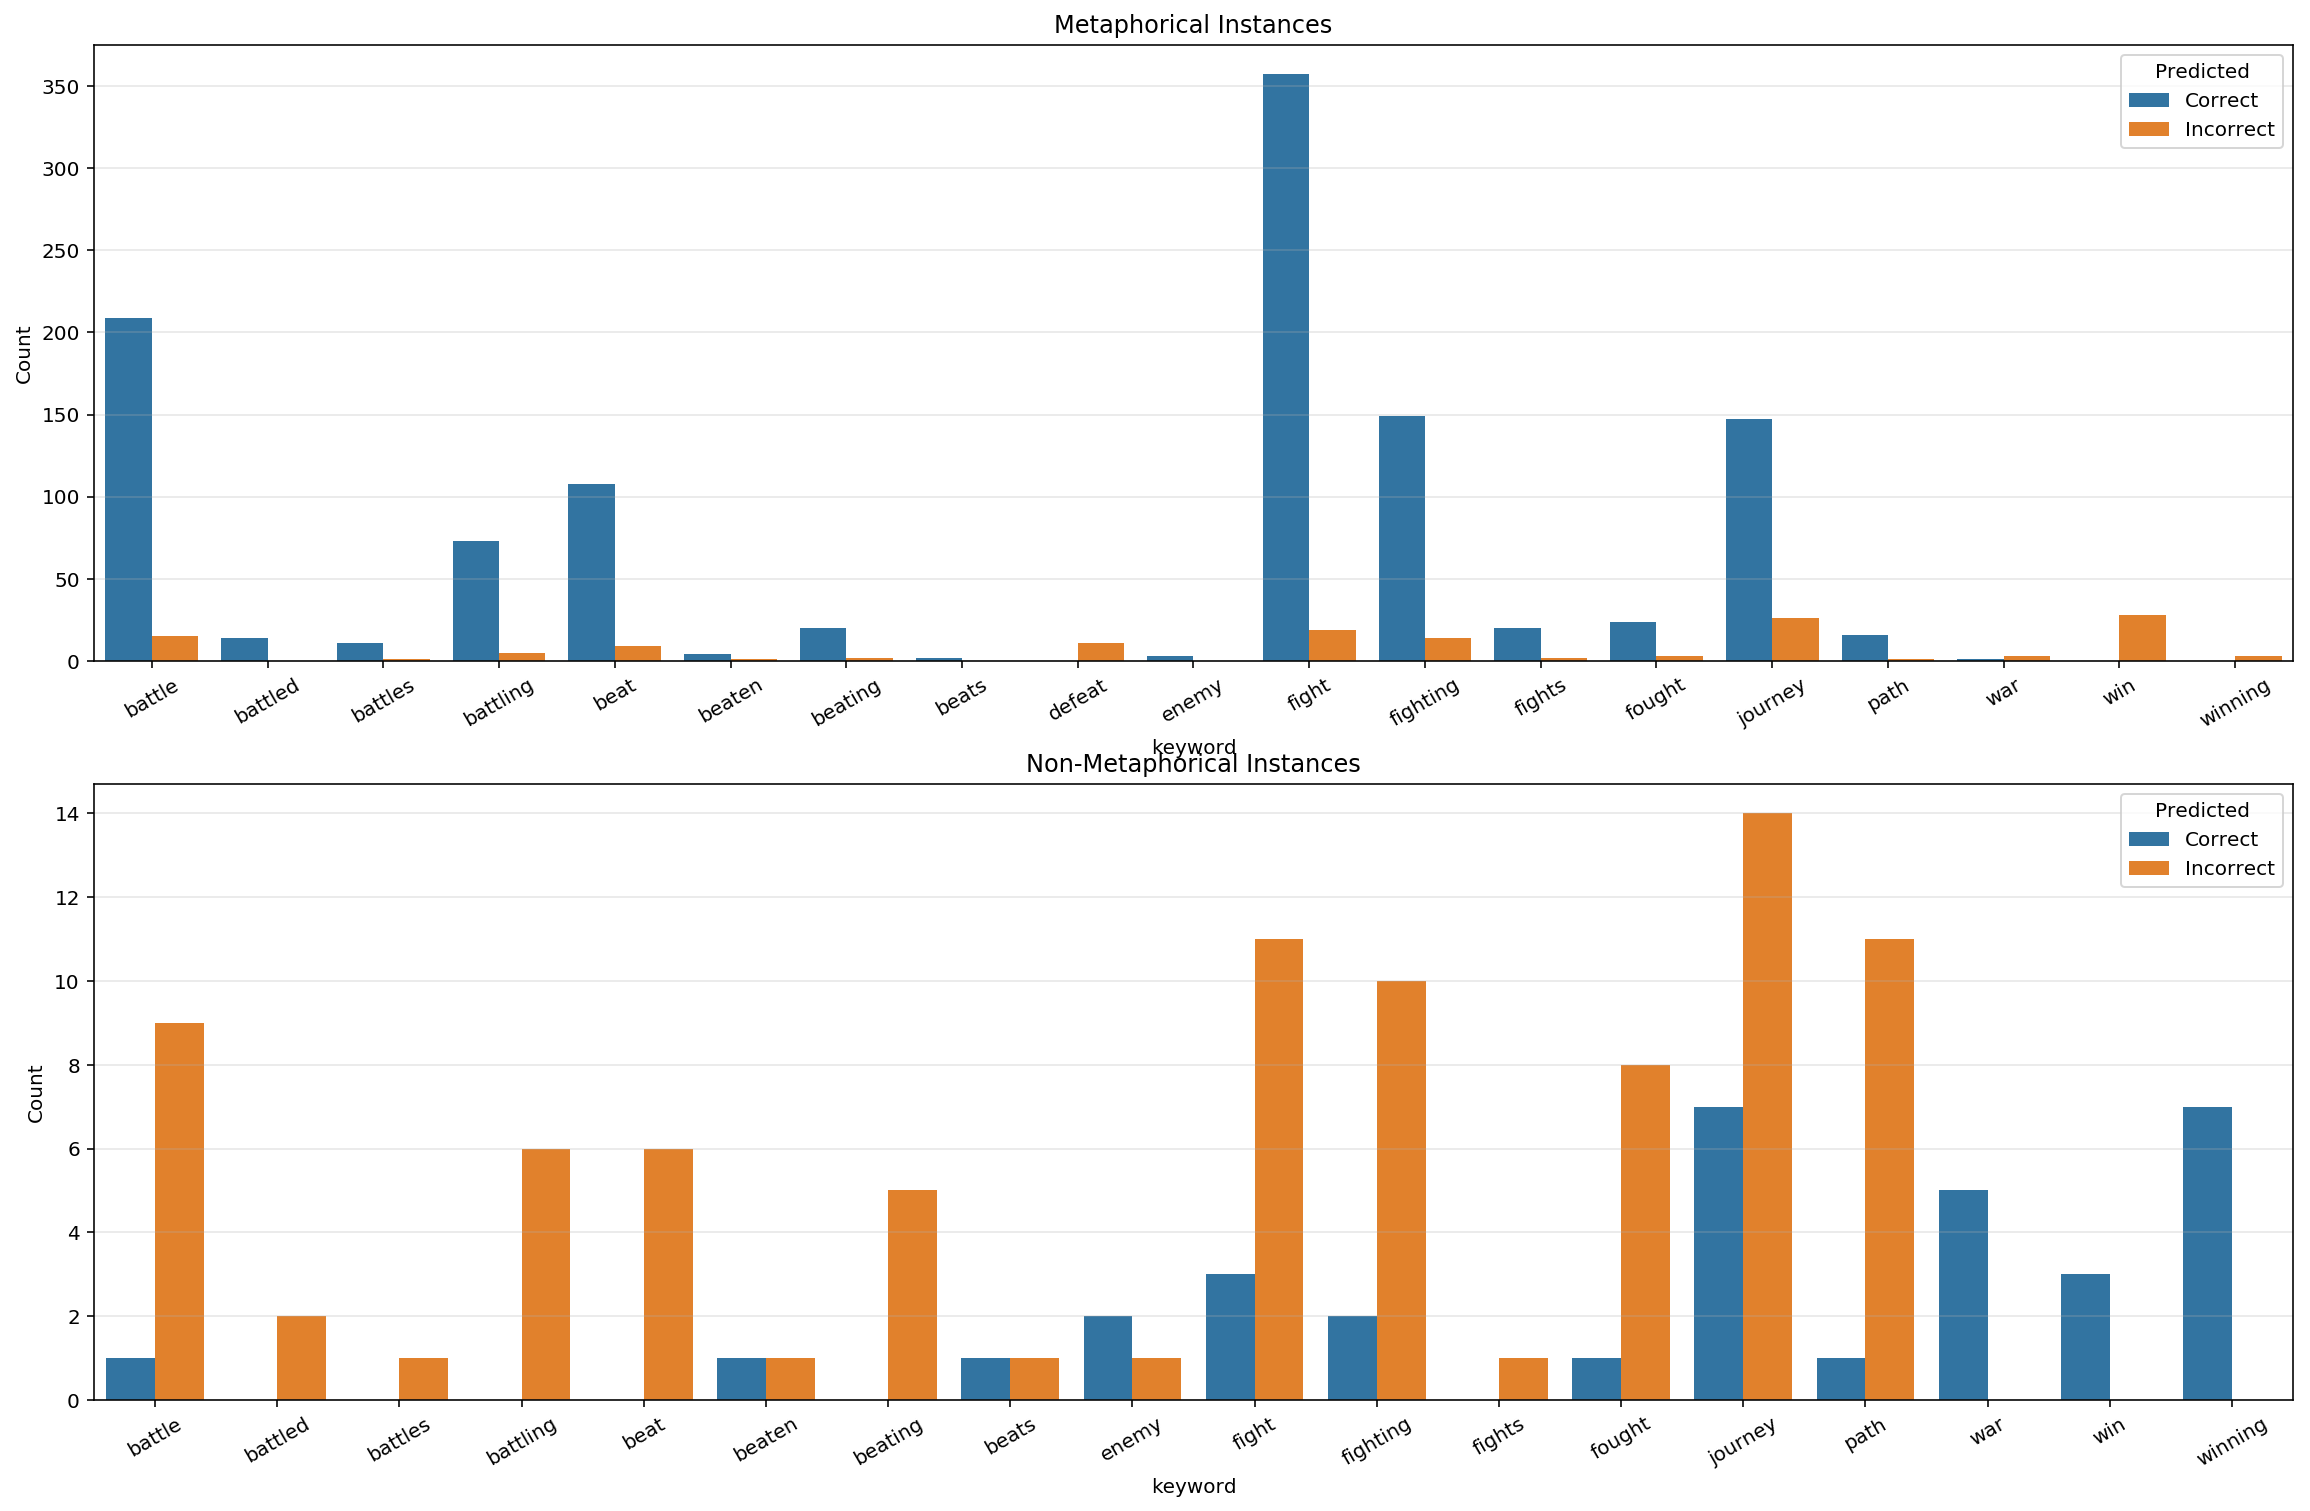

In [22]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

# Neural Net Detection

In [ ]:
from tqdm import tqdm_notebook as tqdm

from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

In [24]:
CANCER_TYPES = ["breast cancer", "lung cancer", "leukemia", "prostate cancer", "melanoma",
                 "lymphoma", "bone cancer", "skin cancer", "bladder cancer", "kidney cancer",
                 "brain cancer", "liver cancer", "pancreatic cancer", "testicular cancer",
                 "colon cancer", "cervical cancer", "esophageal cancer", "neuroblastoma"]

KEYWORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'defeat', 'winning', 'win', 'path', 'journey']

In [31]:
neural_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
neural_predicted_labeled['predicted'] = False

In [57]:
def make_features_of_instance(ins):
    features = np.zeros(14)

    features[0] = int(ins.metaphorical)

    if "cancer" in ins.fragment.lower():
        features[1] = 1

    toked_prior = tokenizer.tokenize(ins.fragment.lower()[:int(ins.kw_start)])
    toked_post = tokenizer.tokenize(ins.fragment.lower()[int(ins.kw_start):])[1:]

    if "cancer" in toked_prior[-5:] or "cancer" in toked_post[:5]:
        features[2] = 1

    if sum(1 for ct in CANCER_TYPES if ct in ins.fragment.lower()) > 0:
        features[3] = 1

    features[4] = ins.fragment.lower().count('!')
    features[5] = ins.fragment.lower().count('?')
    features[6] = sum(1 for c in ins.fragment if c.isupper())
    features[7] = tokenizer.tokenize(ins.fragment).count('I')
    features[8] = tokenizer.tokenize(ins.fragment.lower()).count('he')
    features[9] = tokenizer.tokenize(ins.fragment.lower()).count('she')
    features[10] = tokenizer.tokenize(ins.fragment.lower()).count('they')
    features[11] = int('treatment' in ins.fragment.lower())
    features[12] = int('odds' in toked_post or 'chance' in toked_post)
    features[13] = len({'bank', 'insurance'} & set(tokenizer.tokenize(ins.fragment.lower())))
    
    features = np.concatenate([features, (np.array(KEYWORDS) == ins.keyword).astype(int)])
    
    return features

def make_features(metaphor):

    data = np.array([make_features_of_instance(ins) for ins in neural_predicted_labeled.itertuples()])
    
    return data[:, 0], data[:, 1:]

In [26]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [27]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [58]:
features_y, features = make_features('battle')
# journey_features_y, journey_features = make_features('journey')

features.shape #, journey_features.shape

(1422, 32)

In [59]:
fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in neural_predicted_labeled.loc[:, ['fragment', 'kw_start']].itertuples()] #neural_predicted_labeled['type'] == 'battle'

# journey_fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in neural_predicted_labeled.loc[neural_predicted_labeled['type'] == 'journey', ['fragment', 'kw_start']].itertuples()]


In [60]:
# battle_embds = elmo.embed_sentences(battle_fragments)
# battle_embedded_fragments = np.array([embd[2] for embd in tqdm(battle_embds)])
# journey_embds = elmo.embed_sentences(journey_fragments)
# journey_embedded_fragments = np.array([embd[2] for embd in tqdm(journey_embds)])

embds = elmo.embed_sentences(fragments)
embedded_fragments = np.array([embd[2] for embd in tqdm(embds)])

In [61]:
embedded_fragments.shape #, journey_embedded_fragments.shape

(1422, 20, 1024)

In [62]:
# y_data_battle = neural_predicted_labeled.loc[neural_predicted_labeled['type'] == 'battle', 'metaphorical'].astype(int).values
# y_data_journey = neural_predicted_labeled.loc[neural_predicted_labeled['type'] == 'journey', 'metaphorical'].astype(int).values

y_data = neural_predicted_labeled.loc[:, 'metaphorical'].astype(int).values


In [38]:
from keras import backend as K
from keras.models import Model, load_model
from sklearn import metrics

Using TensorFlow backend.


In [39]:
battle_model = load_model('combined_battle_model.h5')
journey_model = load_model('combined_journey_model.h5')

In [63]:
for ix in tqdm(neural_predicted_labeled.index):

    type_ = neural_predicted_labeled.at[ix, 'type']
    
    if type_ == 'battle':
        mod = battle_model
    else:
        mod = journey_model
        
    pred = (mod.predict([[features[ix]], [embedded_fragments[ix]]]) > 0.5).astype(bool)[0][0]
#     print(pred)
    neural_predicted_labeled.at[ix, 'predicted'] = pred

## Results

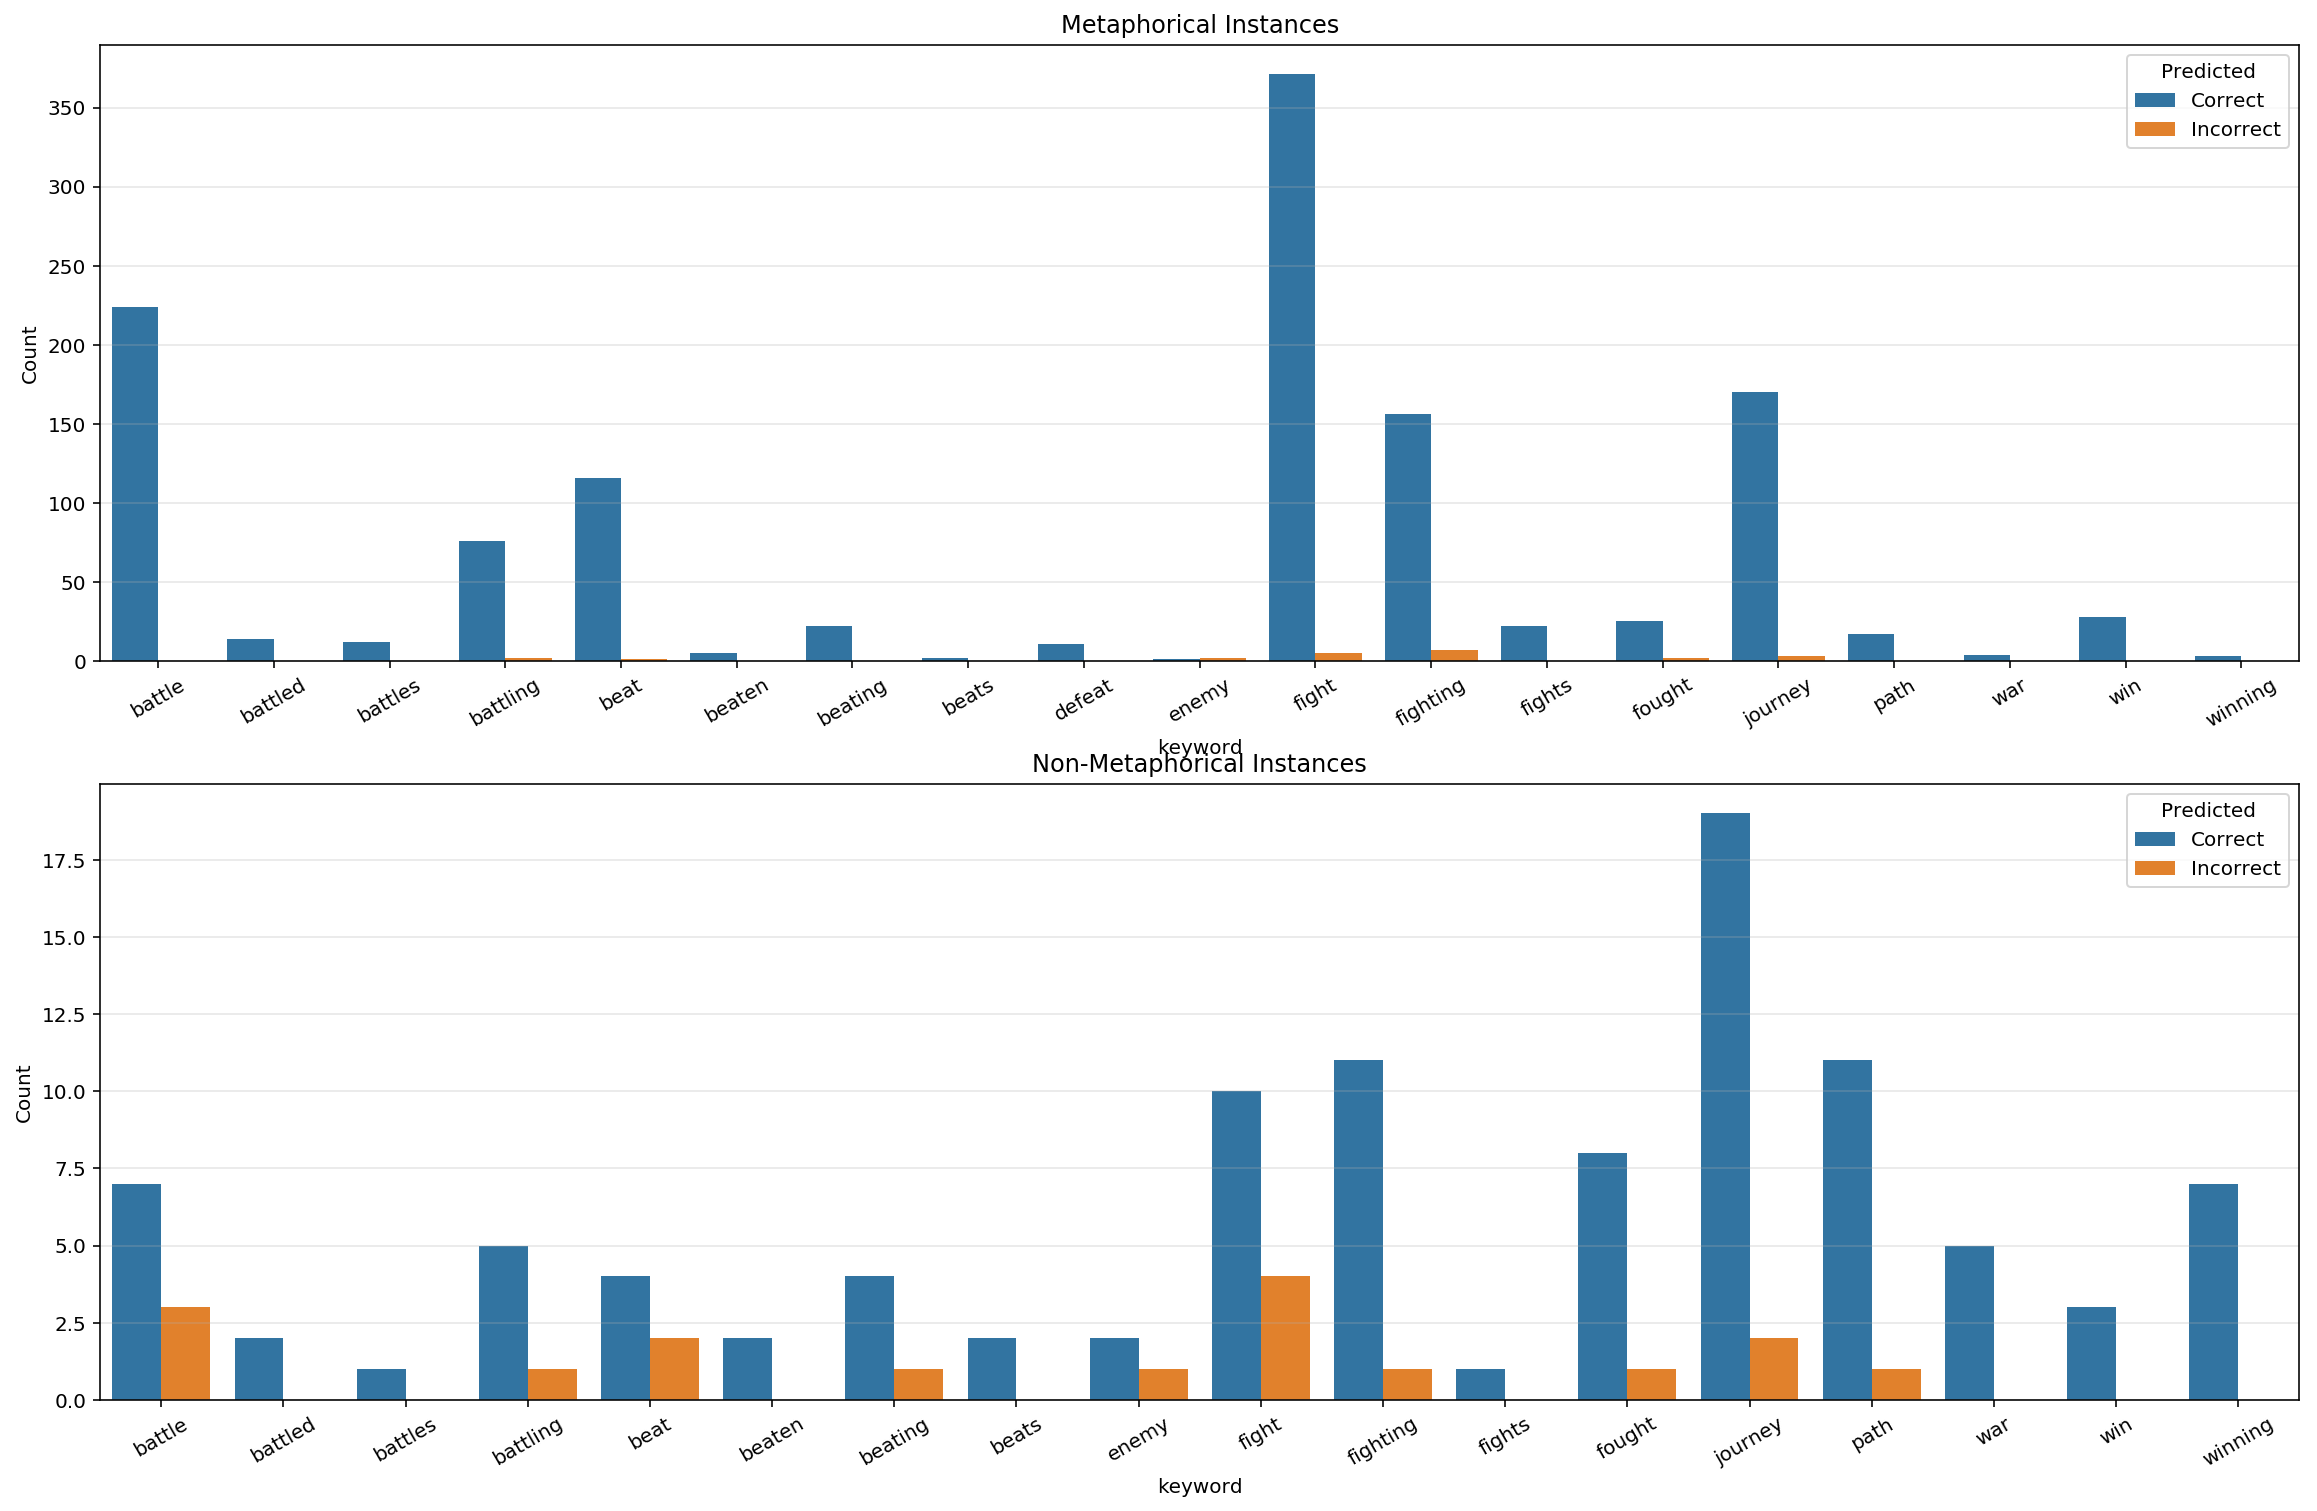

In [64]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Model Comparison

In [65]:
pd.crosstab(regex_predicted_labeled['metaphorical'], regex_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)

Predicted,False,True,All
Truth,,,
False,34,87,121
True,143,1158,1301
All,177,1245,1422


In [66]:
pd.crosstab(neural_predicted_labeled['metaphorical'], neural_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)

Predicted,False,True,All
Truth,,,
False,104,17,121
True,22,1279,1301
All,126,1296,1422


In [67]:
print('Regex Model Cohen\'s Kappa:')
print(f"{metrics.cohen_kappa_score(regex_predicted_labeled['metaphorical'].astype(bool), regex_predicted_labeled['predicted']):.3f}")
print('Neural Model Cohen\'s Kappa:')
print(f"{metrics.cohen_kappa_score(neural_predicted_labeled['metaphorical'].astype(bool), neural_predicted_labeled['predicted']):.3f}")

Regex Model Cohen's Kappa:
0.141
Neural Model Cohen's Kappa:
0.827
